In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
sys.path.append('/home/bkovalenko/experiments/coco/coco/PythonAPI')
from pycocotools.coco import COCO

In [66]:
from __future__ import print_function

import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

from keras.models import Sequential, Merge
from keras.layers import Embedding, TimeDistributed, GRU, RepeatVector, Activation

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
image_model = Sequential()
# image_model.add(Input(shape=(224, 224, 3)))

# Block 1
image_model.add(Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1', input_shape=(224, 224, 3)))
image_model.add(Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2'))
image_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
image_model.add(Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1'))
image_model.add(Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2'))
image_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
image_model.add(Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1'))
image_model.add(Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2'))
image_model.add(Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3'))
image_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
image_model.add(Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1'))
image_model.add(Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2'))
image_model.add(Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3'))
image_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
image_model.add(Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1'))
image_model.add(Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2'))
image_model.add(Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3'))
image_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

image_model.add(GlobalMaxPooling2D())

In [5]:
image_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [6]:
example = image.load_img('/home/bkovalenko/experiments/coco/images/train/train2014/COCO_train2014_000000124240.jpg', 
                         target_size=(224, 224))
example = image.img_to_array(example)
example = example.reshape((1, 224, 224, 3)).astype(np.float64)
print(example.shape)

(1, 224, 224, 3)


In [7]:
example = preprocess_input(example, dim_ordering='th')
print(example.shape)

(1, 224, 224, 3)


In [8]:
features = image_model.predict(example)
print(features.shape)

(1, 512)


-------

In [9]:
def get_images_paths(folder=None, exten='jpg'):
    all_images = []
    for filename in os.listdir(folder):
        if filename.endswith("."+exten):
            all_images.append(os.path.join(folder, filename))
            continue
        else:
            continue

    return np.array(all_images)

In [10]:
all_images = get_images_paths(folder='/home/bkovalenko/experiments/coco/images/train/train2014/', exten='jpg')
print(len(all_images))

82783


In [11]:
all_image_ids = [int(x.split('_')[2].rstrip('.jpg').lstrip('0')) for x in all_images]
print(len(all_image_ids))

82783


-------

In [12]:
text_data = COCO(annotation_file='/home/bkovalenko/experiments/coco/annotations/captions_train2014.json')

loading annotations into memory...
Done (t=1.78s)
creating index...
index created!


In [13]:
all_captions = text_data.loadAnns(text_data.getAnnIds(imgIds=all_image_ids))

In [14]:
sentences = [x[u'caption'] for x in all_captions]

In [15]:
words2id_count = {}
words = 0

for senten in sentences:
    for word in senten.split(' '):
        word = ''.join(x for x in word.lower() if x.isalpha()) 
        if word in words2id_count:
            words2id_count[word] = (words2id_count[word][0], words2id_count[word][1] + 1)
        else:
            words2id_count[word] = (words, 1)
            words += 1

In [16]:
wid = 100
print(words2id_count.keys()[wid])
print(words2id_count.values()[wid])

fir
(10481, 11)


In [17]:
words2id_count[u'riding']

(157, 12673)

In [18]:
# print(len(words2id_count))

# for x in words2id_count.keys():
#     if words2id_count[x][1] < 0 or words2id_count[x][1] > 100:
#         del(words2id_count[x])
        
# print(len(words2id_count))

In [19]:
words2id_count['UNKNWN'] = (len(words2id_count)+1, 0)

-------

In [20]:
# next, let's define a RNN model that encodes sequences of words
# into sequences of 128-dimensional word vectors.
language_model = Sequential()
language_model.add(Embedding(len(words2id_count), 512, input_length=16))
language_model.add(GRU(output_dim=128, return_sequences=True))
language_model.add(TimeDistributed(Dense(128)))

In [21]:
# let's repeat the image vector to turn it into a sequence.
image_model.add(RepeatVector(16))

In [22]:
# the output of both models will be tensors of shape (samples, max_caption_len, 128).
# let's concatenate these 2 vector sequences.
model = Sequential()
model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))

In [23]:
# let's encode this vector sequence into a single vector
model.add(GRU(256, return_sequences=False))

# which will be used to compute a probability
# distribution over what the next word in the caption should be!
model.add(Dense(len(words2id_count)))
model.add(Activation('softmax'))

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

-----

In [25]:
# example = example.reshape(224, 224, 3)
# images = np.array([example, example])
# print(images.shape)

# partial_captions = np.array([[1,5,3,2, marker,marker,marker,marker,marker,marker,marker,marker,marker,marker,marker,marker],
#                              [4,5,6,2, marker,marker,marker,marker,marker,marker,marker,marker,marker,marker,marker,marker]])
# print(partial_captions.shape)

In [26]:
# next_words = np.zeros((2, 6869))
# next_words[0, 50] = 1
# next_words[0, 2] = 1

In [27]:
# "images" is a numpy float array of shape (nb_samples, nb_channels=3, width, height).
# "captions" is a numpy integer array of shape (nb_samples, max_caption_len)
# containing word index sequences representing partial captions.
# "next_words" is a numpy float array of shape (nb_samples, vocab_size)
# containing a categorical encoding (0s and 1s) of the next word in the corresponding
# partial caption.
# model.fit([images, partial_captions], next_words, batch_size=1, nb_epoch=1)

-----

COCO_train2014_000000124240.jpg

In [28]:
print(len(words2id_count))

24414


In [79]:
def prepare_batch(images_path=None, image_batch_size=4):
    while 1:
        # choose images
        indices = np.random.randint(0, images_path.shape[0], image_batch_size)
        sample = images_path[indices]
        
        # image ids
        image_ids = [int(x.split('_')[2].rstrip('.jpg').lstrip('0')) for x in sample]
        
        # load images
        loaded_images = [image.img_to_array(image.load_img(x, target_size=(224, 224))) for x in sample]
        
        # load caps and normalize them
        caps = [(x[u'caption'], x[u'image_id']) for x in text_data.loadAnns(ids=text_data.getAnnIds(imgIds=image_ids))]
        normalized_caps = []
        for x in zip(*caps)[0]:
            tmp_cap = []
            for w in x.split(' '):
                w = ''.join(x for x in w.lower() if x.isalpha()).strip(' ')
                if len(w) < 2:
                    continue
                try:
                    tmp_cap.append(words2id_count[w][0])
                except:
                    tmp_cap.append(words2id_count['UNKNWN'][0])
                    
            normalized_caps.append(tmp_cap)
            
        # repeat image vectors
        repeated_imvec = []
        for i, img_id in enumerate(image_ids):
            im_count = zip(*caps)[1].count(img_id)
            repeated_imvec += [loaded_images[i]]*im_count
            
        # prepare training sequences and targets
        training_seq = []
        target_words = []
        for sent in normalized_caps:
            sent = sent[:17]
            indx = np.random.randint(low=1, high=len(sent), size=1)[0]
            
            targ = np.zeros(len(words2id_count))
            targ[sent[indx:]] = 1
            
            training_seq.append(sent[:indx] + [words2id_count['UNKNWN'][0]]*(16-len(sent[:indx])))
            target_words.append(targ)
            
        if len(repeated_imvec) != len(target_words) or len(repeated_imvec) != len(training_seq):
            continue
        
        yield [np.array(repeated_imvec), np.array(training_seq).reshape((-1, 16))], np.array(target_words)
#         break

In [80]:
# xx = prepare_batch(images_path=all_images)
# print(xx[0][0].shape, xx[0][1].shape, xx[1].shape)

-----

In [81]:
data_stream = prepare_batch(images_path=all_images, image_batch_size=32)

In [82]:
model.fit_generator(generator=data_stream, samples_per_epoch=10000, nb_epoch=10)

Epoch 1/10
10085/10000 [==============================] - 154s - loss: 32.6889     

In [54]:
example.shape

(1, 224, 224, 3)

In [75]:
begining = np.zeros((1, 16))
begining[0] = words2id_count['bathroom'][0]

In [76]:
res = model.predict([example, begining])

In [77]:
np.argmax(res)

28

In [78]:
for x in words2id_count:
    if words2id_count[x][0] == 28:
        print(x)

in


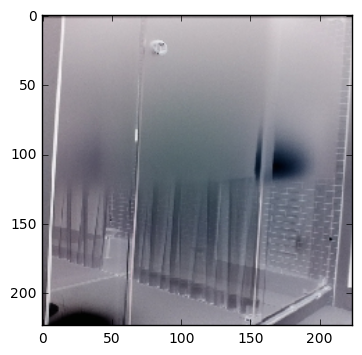

In [68]:
plt.imshow(example.reshape(224, 224, 3))

In [71]:
text_data.loadAnns(text_data.getAnnIds(imgIds=[124240]))

[{u'caption': u'The shower doors are still foggy for the temp of the water.',
  u'id': 813159,
  u'image_id': 124240},
 {u'caption': u'A  partially stained glass bathroom shower door with white curtains.',
  u'id': 813774,
  u'image_id': 124240},
 {u'caption': u'A mirror showing a window with curtains hanging from the window',
  u'id': 814650,
  u'image_id': 124240},
 {u'caption': u'a bath room with a shower and a curtain',
  u'id': 816907,
  u'image_id': 124240},
 {u'caption': u'A steamed up mirrored door in a bathroom',
  u'id': 817632,
  u'image_id': 124240}]